In [15]:
import stumpy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import os
import sys
import logging

logging.basicConfig(level=logging.INFO)

In [16]:
current = os.path.dirname(os.path.realpath(sys.argv[0]))
parent = os.path.dirname(current)
sys.path.append(parent)

from MSig import Motif, NullModel

In [17]:
#read the data
colnames = ['datetime', "sum_terminals", "sum_roaming_terminals", "sum_phonecalls"]
data = pd.read_csv("../data/populationdensity/hourly_saodomingosbenfica.csv", usecols=colnames, parse_dates=['datetime'])
data = data.set_index('datetime').sort_index()
data.columns = ['Terminals', 'Roaming Terminals', 'Phone Calls']
data

,Terminals,Roaming Terminals,Phone Calls
datetime,,,
2021-09-15 00:00:00,228256.0,3838.0,1788.0
2021-09-15 01:00:00,236425.0,3701.0,1102.0
2021-09-15 02:00:00,223600.0,3377.0,598.0
2021-09-15 03:00:00,194192.0,2637.0,285.0
2021-09-15 04:00:00,261136.0,3287.0,182.0
...,...,...,...
2021-11-30 19:00:00,316390.0,4018.0,16637.0
2021-11-30 20:00:00,351831.0,4491.0,18158.0
2021-11-30 21:00:00,311190.0,4149.0,13265.0


In [18]:
X = data.to_numpy().astype(np.float64).T
X

array([[228256., 236425., 223600., ..., 311190., 323163., 314228.],
       [  3838.,   3701.,   3377., ...,   4149.,   4253.,   4218.],
       [  1788.,   1102.,    598., ...,  13265.,  12492.,  11377.]])

In [19]:
include = None
normalize = True
subsequence_lengths = [6,12,24,48]

In [20]:
for m in subsequence_lengths:
    mp, mp_indices = stumpy.mstump(X, m, include=include, normalize=normalize)
    np.save('../results/populationdensity/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp)
    np.save('../results/populationdensity/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp_indices)

In [21]:
def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    
    model_empirical = NullModel(data, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        #if is empty, skip
        if len(match_indices) == 0:
            continue
        
        #remove trivial matches  
        non_trivial_matches = []
        for indice in match_indices:
           trivial = False
           for indice_new in non_trivial_matches:
               if abs(indice - indice_new) <= m/2:
                   trivial = True
                   break
           if not trivial:
               non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time-m)/np.ceil(m/2)+1))


        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]
    
        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=1)
            max_allowed_dist = np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
            

        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # dist_media_elemento = SQRT((dist^2)/n_length)
        #max_delta = max_allowed_dist        # dist_max do motif = dist_max de um elemento (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m) 
        delta_thresholds = [max_delta]*len(data)

        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, len(match_indices))
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(max_possible_matches, n_vars, idd_correction=False) 

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [22]:
k = None
min_neighbors = 1
cutoffs = np.inf
max_matches = 99999
average_delta = 0.3
max_dists = []
max_motifs = 99999
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    max_distance = math.sqrt(m)*average_delta
    max_dists.append(max_distance)

    excl_zone = int(np.ceil(m/2))

    mp= np.load('../results/populationdensity/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    mp_indices = np.load('../results/populationdensity/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(X, mp, mp_indices, max_distance=max_distance,max_matches=max_matches,
                                                                                 cutoffs=cutoffs, min_neighbors=min_neighbors, max_motifs=max_motifs, k=k, include=include, normalize=normalize)

    if len(motif_indices[0]) == 0:
        continue
    print("m:{}, #Motifs:{}".format(m, len(motif_indices)))  
    table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance)
    print("Sig ", np.sum(table["p-value"] < 0.01))

    #hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value =  NullModel.hochberg_critical_value(p_values, 0.05)
    sig = table["p-value"] < critical_value if critical_value != 0 else table["p-value"] <= critical_value
    table["Sig_Hochber"] = sig

    print("Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value))


    mp_stats_table = pd.concat([mp_stats_table, table], ignore_index=True)

mp_stats_table.to_csv('../results/populationdensity/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_dists, cutoffs, max_matches, max_motifs), index=False)

m:6, #Motifs:82


INFO:root:p_value = 5.303E-104 (p_pattern = 3.929E-09)
INFO:root:p_value = 8.936E-80 (p_pattern = 5.206E-03)
INFO:root:p_value = 1.169E-02 (p_pattern = 4.308E-02)
INFO:root:p_value = 2.718E-02 (p_pattern = 1.499E-01)
INFO:root:p_value = 7.633E-199 (p_pattern = 6.857E-05)
INFO:root:p_value = 1.702E-19 (p_pattern = 8.181E-03)
INFO:root:p_value = 6.041E-50 (p_pattern = 8.180E-04)
INFO:root:p_value = 4.440E-177 (p_pattern = 4.786E-04)
INFO:root:p_value = 8.345E-290 (p_pattern = 4.054E-05)
INFO:root:p_value = 8.760E-69 (p_pattern = 1.716E-05)
INFO:root:p_value = 1.720E-06 (p_pattern = 1.328E-04)
INFO:root:p_value = 8.930E-118 (p_pattern = 1.240E-06)
INFO:root:p_value = 5.195E-63 (p_pattern = 2.424E-04)
INFO:root:p_value = 2.300E-119 (p_pattern = 3.460E-04)
INFO:root:p_value = 5.729E-25 (p_pattern = 2.545E-02)
INFO:root:p_value = 3.250E-175 (p_pattern = 5.559E-05)
INFO:root:p_value = 7.188E-53 (p_pattern = 2.359E-05)
INFO:root:p_value = 9.711E-35 (p_pattern = 2.838E-03)
INFO:root:p_value = 2

Sig  49
Sig after Hochberg: 54, critical value: 0.02717979013843905


INFO:root:p_value = 6.075E-12 (p_pattern = 1.138E-05)


m:12, #Motifs:62


INFO:root:p_value = 3.225E-310 (p_pattern = 1.893E-11)
INFO:root:p_value = 8.332E-279 (p_pattern = 4.811E-06)
INFO:root:p_value = 1.627E-186 (p_pattern = 1.266E-04)
INFO:root:p_value = 3.793E-155 (p_pattern = 4.772E-05)
INFO:root:p_value = 1.395E-142 (p_pattern = 7.885E-04)
INFO:root:p_value = 4.350E-90 (p_pattern = 2.323E-04)
INFO:root:p_value = 1.798E-112 (p_pattern = 3.497E-08)
INFO:root:p_value = 1.588E-20 (p_pattern = 1.493E-09)
INFO:root:p_value = 4.496E-12 (p_pattern = 4.604E-05)
INFO:root:p_value = 4.837E-07 (p_pattern = 4.678E-05)
INFO:root:p_value = 9.480E-58 (p_pattern = 1.475E-03)
INFO:root:p_value = 5.634E-237 (p_pattern = 3.138E-09)
INFO:root:p_value = 8.360E-39 (p_pattern = 1.709E-03)
INFO:root:p_value = 3.723E-68 (p_pattern = 3.071E-07)
INFO:root:p_value = 6.087E-40 (p_pattern = 2.671E-03)
INFO:root:p_value = 6.043E-61 (p_pattern = 1.734E-04)
INFO:root:p_value = 1.876E-180 (p_pattern = 5.023E-07)
INFO:root:p_value = 3.028E-02 (p_pattern = 8.769E-04)
INFO:root:p_value = 

Sig  55
Sig after Hochberg: 56, critical value: 0.0302787678843667


INFO:root:p_value = 8.920E-41 (p_pattern = 4.205E-09)
INFO:root:p_value = 6.703E-07 (p_pattern = 7.595E-06)


m:24, #Motifs:70


INFO:root:p_value = 6.378E-19 (p_pattern = 1.029E-08)
INFO:root:p_value = 2.356E-56 (p_pattern = 2.028E-06)
INFO:root:p_value = 1.329E-146 (p_pattern = 8.289E-12)
INFO:root:p_value = 1.398E-117 (p_pattern = 3.957E-11)
INFO:root:p_value = 3.581E-16 (p_pattern = 1.755E-10)
INFO:root:p_value = 5.674E-133 (p_pattern = 2.591E-12)
INFO:root:p_value = 1.082E-13 (p_pattern = 3.051E-09)
INFO:root:p_value = 7.179E-20 (p_pattern = 2.485E-12)
INFO:root:p_value = 3.256E-78 (p_pattern = 5.190E-12)
INFO:root:p_value = 2.795E-85 (p_pattern = 1.121E-11)
INFO:root:p_value = 1.066E-29 (p_pattern = 3.028E-17)
INFO:root:p_value = 5.095E-74 (p_pattern = 1.429E-09)
INFO:root:p_value = 8.921E-114 (p_pattern = 7.764E-11)
INFO:root:p_value = 2.140E-79 (p_pattern = 9.920E-08)
INFO:root:p_value = 7.118E-12 (p_pattern = 2.474E-08)
INFO:root:p_value = 4.099E-20 (p_pattern = 1.877E-12)
INFO:root:p_value = 3.139E-34 (p_pattern = 6.149E-11)
INFO:root:p_value = 5.174E-25 (p_pattern = 1.239E-08)
INFO:root:p_value = 1.22

Sig  69
Sig after Hochberg: 69, critical value: 0.01024724176861342


INFO:root:p_value = 4.830E-40 (p_pattern = 1.901E-15)
INFO:root:p_value = 2.237E-59 (p_pattern = 6.827E-22)
INFO:root:p_value = 1.766E-13 (p_pattern = 2.324E-15)
INFO:root:p_value = 9.958E-30 (p_pattern = 5.911E-17)


m:48, #Motifs:26


INFO:root:p_value = 3.420E-30 (p_pattern = 3.464E-17)
INFO:root:p_value = 6.547E-47 (p_pattern = 8.452E-14)
INFO:root:p_value = 2.907E-47 (p_pattern = 7.450E-18)
INFO:root:p_value = 7.428E-47 (p_pattern = 8.723E-14)
INFO:root:p_value = 1.404E-28 (p_pattern = 2.219E-16)
INFO:root:p_value = 2.263E-40 (p_pattern = 2.818E-22)
INFO:root:p_value = 1.556E-23 (p_pattern = 7.388E-14)
INFO:root:p_value = 1.786E-39 (p_pattern = 2.940E-15)
INFO:root:p_value = 1.392E-33 (p_pattern = 6.988E-19)
INFO:root:p_value = 2.116E-31 (p_pattern = 1.444E-12)
INFO:root:p_value = 1.302E-38 (p_pattern = 5.700E-15)
INFO:root:p_value = 1.131E-35 (p_pattern = 6.299E-20)
INFO:root:p_value = 8.101E-38 (p_pattern = 5.331E-21)
INFO:root:p_value = 6.243E-32 (p_pattern = 4.680E-18)
INFO:root:p_value = 3.831E-28 (p_pattern = 3.667E-16)
INFO:root:p_value = 1.999E-52 (p_pattern = 2.648E-28)
INFO:root:p_value = 3.427E-24 (p_pattern = 3.468E-14)
INFO:root:p_value = 5.440E-44 (p_pattern = 9.181E-17)
INFO:root:p_value = 6.231E-3

Sig  26
Sig after Hochberg: 25, critical value: 1.765918610451223e-13


In [23]:
#create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std, 
#average probability +- std, average pvalue +- std)
mp_stats_table = pd.read_csv('../results/populationdensity/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_dists, cutoffs, max_matches, max_motifs))

motif_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(columns=["m", "#motifs" , "avg_n_matches", "avg_n_features",  "avg_probability",  "avg_pvalue", "#sig_motifs(<0.01)", "significant", "#sig_hochberg"])
for m in motif_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    n_motifs = table.shape[0]
    n_sig_motifs_001 = table[table["p-value"] < 0.01].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"] == True].shape[0]
    avg_n_matches = round(table["#Matches"].mean(),2), round(table["#Matches"].std(),3)
    avg_n_features = round(table["k"].mean(),2), round(table["k"].std(),3)
    avg_probability = table["P"].mean(), table["P"].std()    
    avg_pvalue = table["p-value"].mean(), table["p-value"].std()

    stats_df = {"m": m, "#motifs": n_motifs, "#sig_motifs(<0.01)": n_sig_motifs_001, "significant":(n_sig_motifs_001*100)/n_motifs,"#sig_hochberg": n_sig_motifs_hochberg,
                "avg_n_matches": avg_n_matches, "avg_n_features": avg_n_features, "avg_probability": avg_probability, "avg_pvalue": avg_pvalue}
    motif_stats_table = pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)

motif_stats_table

,m,#motifs,avg_n_matches,avg_n_features,avg_probability,avg_pvalue,#sig_motifs(<0.01),significant,#sig_hochberg
0,6,82,"(18.83, 25.282)","(1.04, 0.189)","(0.008623117560400444, 0.019990018073446966)","(0.2127964701018348, 0.3702932942727789)",49,59.756098,54
1,12,62,"(12.82, 17.301)","(1.03, 0.178)","(0.0019376146248065173, 0.005886578609760048)","(0.049048299857997836, 0.19967471715217636)",55,88.709677,56
2,24,70,"(3.54, 3.574)","(1.01, 0.12)","(4.172647753000804e-05, 0.0003454729811980506)","(0.00014640342493079178, 0.0012247779271063173)",69,98.571429,69
3,48,26,"(1.38, 0.697)","(1.0, 0.0)","(6.68382410465012e-14, 2.821289476077498e-13)","(6.791994656311829e-15, 3.4632513284879706e-14)",26,100.000000,25


In [24]:
motif_stats_table_print = motif_stats_table.copy()
motif_stats_table_print["avg_n_matches"] = motif_stats_table["avg_n_matches"].apply(lambda x: "{:.2f} +- {:.2f}".format(x[0], x[1]))
motif_stats_table_print["avg_n_features"] = motif_stats_table["avg_n_features"].apply(lambda x: "{:.2f} +- {:.2f}".format(x[0], x[1]))
motif_stats_table_print["avg_probability"] = motif_stats_table["avg_probability"].apply(lambda x: "{:.2e} +- {:.2e}".format(x[0], x[1]))
motif_stats_table_print["avg_pvalue"] = motif_stats_table["avg_pvalue"].apply(lambda x: "{:.2e} +- {:.2e}".format(x[0], x[1]))
print(motif_stats_table_print.to_latex(index=False))

\begin{tabular}{lllllllrl}
\toprule
 m & \#motifs &  avg\_n\_matches & avg\_n\_features &      avg\_probability &           avg\_pvalue & \#sig\_motifs(<0.01) &  significant & \#sig\_hochberg \\
\midrule
 6 &      82 & 18.83 +- 25.28 &   1.04 +- 0.19 & 8.62e-03 +- 2.00e-02 & 2.13e-01 +- 3.70e-01 &                 49 &    59.756098 &            54 \\
12 &      62 & 12.82 +- 17.30 &   1.03 +- 0.18 & 1.94e-03 +- 5.89e-03 & 4.90e-02 +- 2.00e-01 &                 55 &    88.709677 &            56 \\
24 &      70 &   3.54 +- 3.57 &   1.01 +- 0.12 & 4.17e-05 +- 3.45e-04 & 1.46e-04 +- 1.22e-03 &                 69 &    98.571429 &            69 \\
48 &      26 &   1.38 +- 0.70 &   1.00 +- 0.00 & 6.68e-14 +- 2.82e-13 & 6.79e-15 +- 3.46e-14 &                 26 &   100.000000 &            25 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_30693/3311151714.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(motif_stats_table_print.to_latex(index=False))


In [25]:
#sort by p-value
mp_stats_table = mp_stats_table.sort_values(by="p-value", ascending=True)
mp_stats_table

,ID,k,Features,m,#Matches,Indices,max(dists),min(dists),med(dists),P,p-value,Sig_Hochber
83,1,2,"1,2",12,32,"[1538, 1586, 1562, 314, 650, 435, 723, 290, 12...",1.034,0.221,0.900,1.893066e-11,3.225302e-310,True
8,8,1,2,6,90,"[1460, 808, 356, 1003, 1486, 1774, 235, 1390, ...",0.731,0.073,0.559,4.054157e-05,8.344714e-290,True
84,2,1,2,12,64,"[888, 48, 168, 24, 1656, 120, 1632, 312, 1464,...",1.039,0.133,0.582,4.811276e-06,8.331806e-279,True
94,12,1,2,12,32,"[1660, 364, 172, 413, 52, 245, 725, 942, 892, ...",1.032,0.402,0.894,3.137814e-09,5.633777e-237,True
4,4,1,2,6,69,"[558, 1662, 1614, 534, 318, 222, 30, 1638, 174...",0.729,0.036,0.451,6.857000e-05,7.633149e-199,True
...,...,...,...,...,...,...,...,...,...,...,...,...
70,70,1,1,6,2,"[1306, 1337, 34]",0.606,0.425,0.515,1.991164e-02,9.996117e-01,False
77,77,1,1,6,1,"[1162, 347]",0.519,0.519,0.519,2.058253e-02,9.999612e-01,False
68,68,1,1,6,3,"[1283, 1074, 1480, 717]",0.655,0.423,0.623,2.858646e-02,9.999791e-01,False
19,19,1,1,6,3,"[1619, 1595, 1643, 1046]",0.388,0.172,0.377,3.209266e-02,9.999968e-01,False


In [26]:
#get top 3 most significant for each motif length
for m in motif_lengths:
    print("########## m:{} #########".format(m))
    top_3_motifs = mp_stats_table[mp_stats_table["m"] == m].head(3)
    print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
    print("\n\n")

########## m:6 #########
\begin{tabular}{rrlrrrrrr}
\toprule
 ID &  k & Features &  \#Matches &  max(dists) &  min(dists) &  med(dists) &        P &       p-value \\
\midrule
  8 &  1 &        2 &        90 &       0.731 &       0.073 &       0.559 & 0.000041 & 8.344714e-290 \\
  4 &  1 &        2 &        69 &       0.729 &       0.036 &       0.451 & 0.000069 & 7.633149e-199 \\
  7 &  1 &        2 &        84 &       0.718 &       0.066 &       0.389 & 0.000479 & 4.439942e-177 \\
\bottomrule
\end{tabular}




########## m:12 #########
\begin{tabular}{rrlrrrrrr}
\toprule
 ID &  k & Features &  \#Matches &  max(dists) &  min(dists) &  med(dists) &            P &       p-value \\
\midrule
  1 &  2 &      1,2 &        32 &       1.034 &       0.221 &       0.900 & 1.893066e-11 & 3.225302e-310 \\
  2 &  1 &        2 &        64 &       1.039 &       0.133 &       0.582 & 4.811276e-06 & 8.331806e-279 \\
 12 &  1 &        2 &        32 &       1.032 &       0.402 &       0.894 & 3.137814e-0

/tmp/ipykernel_30693/4290545082.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
/tmp/ipykernel_30693/4290545082.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
/tmp/ipykernel_30693

In [27]:
def plot_motif(ts_list, features,  m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)

        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)
        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig('../results/populationdensity/m='+str(m)+'_motif_'+str(motif_name)+".pdf",bbox_inches='tight')
  
    return None

Motif length:  6


Motif length:  12
Motif length:  24
Motif length:  48


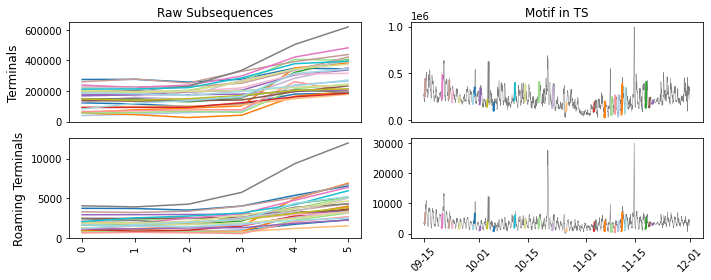

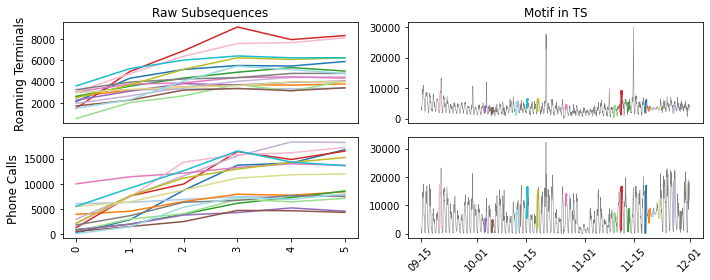

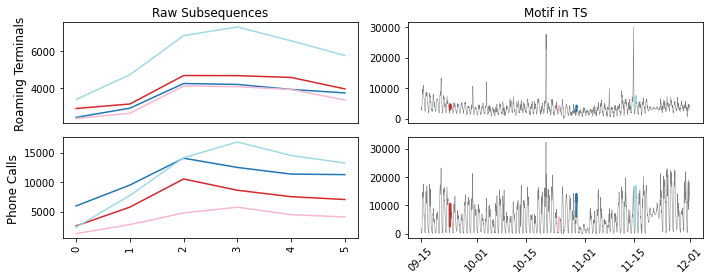

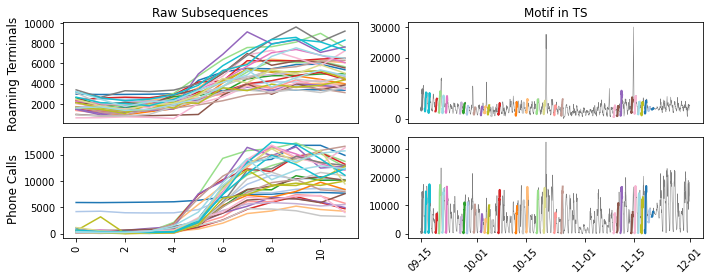

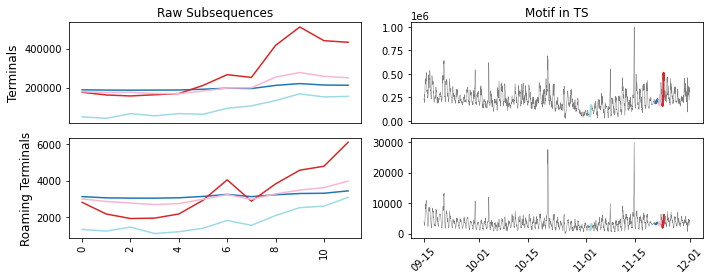

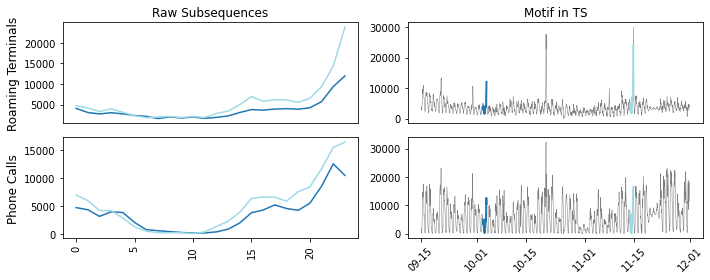

In [28]:
#plot top motif
for m in subsequence_lengths:
    print("Motif length: ", m)
    top_motifs = mp_stats_table[mp_stats_table["m"] == m]
    top_motifs = top_motifs[top_motifs["k"] > 1].sort_values(by="p-value")
    for top_motif in top_motifs.to_dict(orient="records"): 
        m = top_motif["m"]
        dimensions = top_motif["Features"].split(",")
        dimensions = sorted([int(dimension) for dimension in dimensions])
        features = [data.columns[dimension] for dimension in dimensions]
        indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
        indices = [int(i) for i in indices]
        motif_name = top_motif["ID"]
        ts_list = [data[feature] for feature in features]
        plot_motif(ts_list, features, m, indices, motif_name)